<a href="https://colab.research.google.com/github/so-dipe/Data-Science-and-Machine-Learning-Projects/blob/main/Student_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import warnings

import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression

import seaborn as sns

warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# STUDENT Performance

In this notebook, we try to predict the academic performance of some students in Portugal in Math and Portugese. But first, we import the data, clean it and explore.

## Data Importation

In [7]:
MathPerf = pd.read_csv('/content/drive/MyDrive/studentPerformance/student-mat.csv', sep=';')
MathPerf.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


The Dataset has 33 columns, with 3 of them being targets (G1, G2, G3).

Now, we check for missing values in the dataset.


In [8]:
 MathPerf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

As we can see, the Dataset has no missing values. And the columns are mainly of two data types int64 and object.

Next, we check the columns with data type object (string) for low or high cardinality. That is, for constants or columns with completely uniques values.

In [10]:
MathPerf.select_dtypes('object').nunique()

school        2
sex           2
address       2
famsize       2
Pstatus       2
Mjob          5
Fjob          5
reason        4
guardian      3
schoolsup     2
famsup        2
paid          2
activities    2
nursery       2
higher        2
internet      2
romantic      2
dtype: int64

From the above, there are no columns with high or low cardinality, each column at least as two unique values and no column has more than 5.

Looking at the dataset, there are no columns that might constitute leakage (that are highly correlated with the targets but cannot be gotten with knowing the targets themselves). 

Next, we create a version of the dataset, with all categorical data converted to numbers (dummie variables) and check for among the features in the dataset.

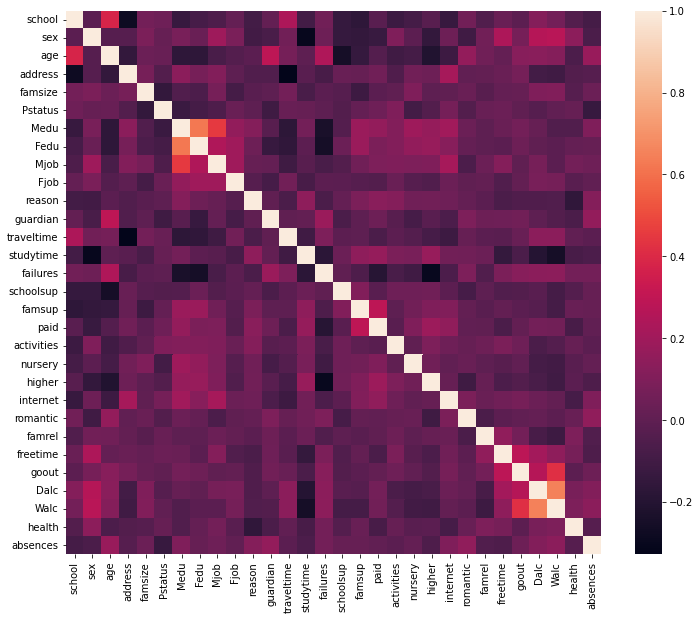

In [11]:
targets = ['G1', 'G2', 'G3']
X = MathPerf.copy().drop(columns=targets)
for column in MathPerf.select_dtypes('object'):
    cat = preprocessing.LabelEncoder()
    cat.fit(MathPerf[column].unique())
    X[column] = cat.transform(X[column])
corr_matrix = X.corr()
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix);

We can see from the heatmap that there isn't much correlation between the features, except for Medu (Mother's Education) and Fedu (Father's Education) and also Dalc (Week-day Alcohol Consmpution) and Walc (Weekend Alcohol Consumption) which show high level of correlation with values around 0.7 to 0.8.

Now, we build the model. 

For this notebook, I'll be using two methods for supervised learning, Classification and Regression.

And although using clasification sounds a little strange considering the targets is numerical data making regression ideal, the targets will be converted to categorical data to make it useable for classification.

For the categories, 
0-9: Fail
10-11: Sufficient
12-13: Satisfactory
14-15: Good
16-20: Excellent

## MODEL: CLASSIFICATION

In [22]:
def outputClass(series_in):
    series = series_in.copy()
    for j in range(len(series)):
        if series[j] <= 9:
            series[j] = 'fail'
        elif series[j] >= 10 and series[j] <= 11:
            series[j] = 'sufficient'
        elif series[j] >= 12 and series[j] <= 13:
            series[j] = 'satisfactory'
        elif series[j] >= 14 and series[j] <= 15:
            series[j] = 'good'
        elif series[j] >= 16:
            series[j] = 'excellent'
    return series

y = outputClass(MathPerf['G1'])

grade_class = preprocessing.LabelEncoder()
grade_class.fit(['fail', 'sufficient', 'satisfactory', 'good', 'excellent'])

LabelEncoder()

The above function outputClass, takes a series as input, in this case the target columns and returns a series as output, the series now representing categorical data. 

After that, the data is passed through a Label Encoder that converts these strings to integers. 

Now we perform the train-test split on the dataset, with 80% of the data used for training

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

### Baseline Model

Since classification problems are like probability, the best baseline to use is to assume every member of feature set belongs to the target set with the most members.

In [24]:
for grade in y.unique():
    num = (y_train == grade).sum()
    print(f'{grade} has {num} members in y_train')

y_train = grade_class.transform(y_train)
y_test = grade_class.transform(y_test)

fail has 109 members in y_train
good has 44 members in y_train
satisfactory has 55 members in y_train
excellent has 34 members in y_train
sufficient has 74 members in y_train


Has we can see, fail has the highest number of memebers. This means that if we always predict that a student fails, disregarding all other features, we will be correct about 33% of the time. since

P(fail) = (109)/(109 + 44 + 55 + 34 + 74) = 109/261 ~ 0.417 = 41%

Therefore, this is the score to beat.

### Classification using K-Nearest Neighbors

To use k-nearest neighbors, we have to try different amount of neighbors (in this case 50) and see which one has the highest accuracy

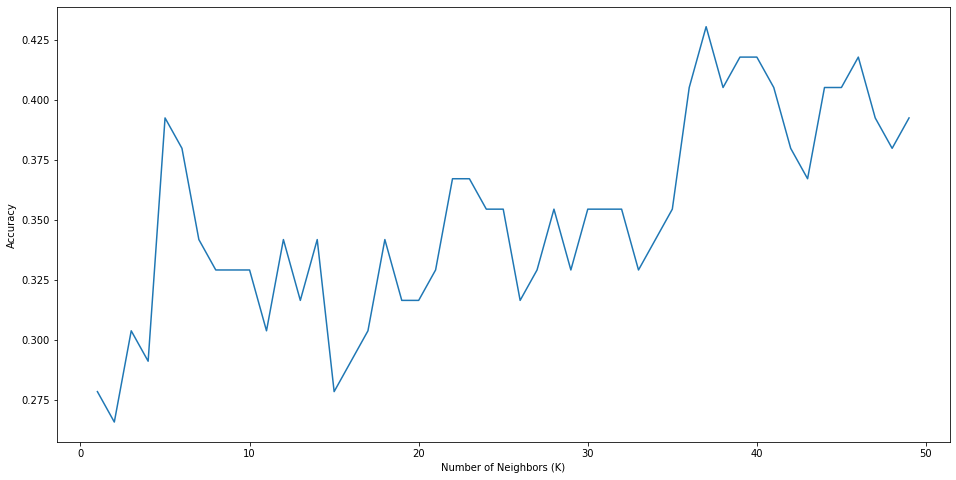

In [25]:
highest_neighbors = 50
mean_accuracy = np.zeros(highest_neighbors-1)
for i in range(1, highest_neighbors):
    neigh = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
    y_hat = neigh.predict(X_test)
    # print('Train set Accuracy for ', i, 'neighbors: ',
        # metrics.accuracy_score(y_train, neigh.predict(X_train)))
    # print('Test set Accuracy: ', i, 'neighbors: ', metrics.accuracy_score(y_test, y_hat))
    mean_accuracy[i-1] = metrics.accuracy_score(y_test, y_hat)

fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(range(1, highest_neighbors), mean_accuracy)
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)');

As we can see from the Accuracy v Neighbors plot above, the model barely beats the baseline. To check the actual value and the number of neighbors that provided the best result, we run the loop below

In [26]:
for i in range(len(mean_accuracy)):
    if mean_accuracy[i] == max(mean_accuracy):
        print(f'The Best value for k is {i+1} with accuracy {round(max(mean_accuracy), 2)}')

The Best value for k is 37 with accuracy 0.43


That's about 43% accuracy, using 37 neighbors, this is just 2% better than the Baseline, so it's not really good enough. 

Since KNN also does not show us the effect of each feature of the prediction, we move on to regression



## MODEL: REGRESSION

Before we create the regression, we do a little more exploration

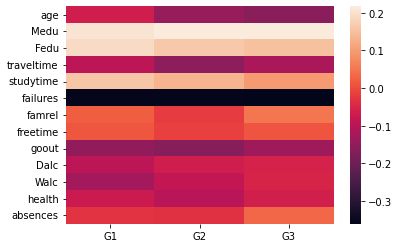

In [27]:
X[targets] = MathPerf[targets]
corr_matrix = MathPerf.corr().drop(index=['G1', 'G2', 'G3'])
sns.heatmap(corr_matrix[['G1', 'G2', 'G3']])
X.drop(columns=['G1', 'G2', 'G3'], inplace=True)

Has we can see then is not much correlation between the features and the columns.

This feels like a bad sign but...

### Baseline Model

The model baseline used this time is the Mean Absolute Error.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, MathPerf['G1'], test_size=0.2, random_state=3 )
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = metrics.mean_absolute_error(y_train, y_pred_baseline).round(2)
baseline_mae

2.76

The baseline prediction of MAE (mean absolute error) is 2.76. 

Therefore, that is the score our model should beat.

In [29]:
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = metrics.mean_absolute_error(y_test, y_pred).round(2)
mae

2.45

The model beats the baseline and as we can see on average, out prediction will be off by about  +/- 2.45.

Next, we check the accuracy score for the prediction made my the regression model, but to do this, we first categorize the values from y_test and y_pred.

In [30]:
y_test_cat = outputClass(y_test.reset_index().drop(columns='index')[y_test.name])
y_pred_cat = outputClass(pd.Series(y_pred.round(0).astype(int)))

y_test_cat_num = grade_class.transform(y_test_cat)
y_pred_cat_num = grade_class.transform(y_pred_cat)

metrics.accuracy_score(y_test_cat_num, y_pred_cat_num)

0.26582278481012656

As we see here, the model has an accuracy score of approximately 27%, which is not even as good as the KNN model. This is understandable since the model has a MAE of 2.46, and most of the categories in the target has contain only 2 number (ex: 10-11, 12-13, ...)